/tmp/ipykernel_1324001/3689762366.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", 20)


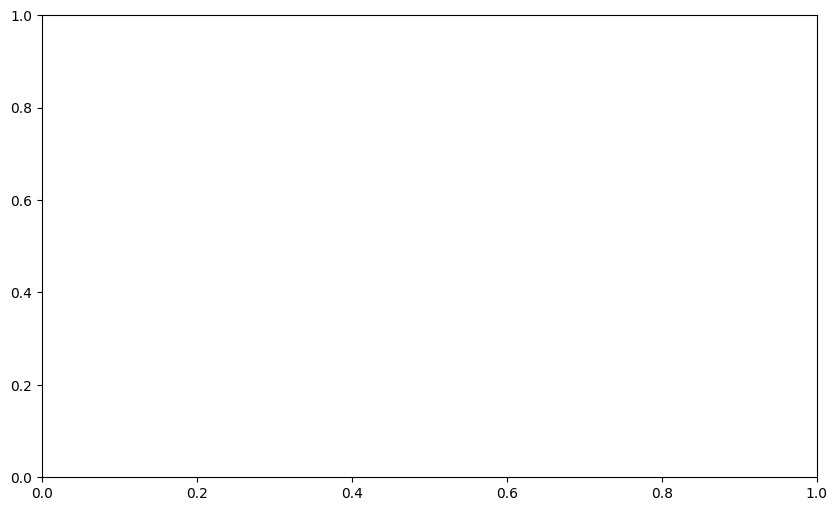

In [37]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from matplotlib import cm
from scipy.optimize import linear_sum_assignment
from scipy.stats import mode
from collections import defaultdict, Counter
from denoiser import *
cmap = cm.get_cmap("tab20", 20)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

In [2]:
radar1 = pd.read_pickle('radar1_s1.pkl')
radar2 = pd.read_pickle('radar2_s1.pkl')

In [3]:
def handle_timesync(df):
    df['datetime'] = df['datetime'].apply(lambda x: pd.to_datetime(x))
    df = df[df.datetime != df['datetime'][0]][df.datetime != df['datetime'][len(df['datetime'])-1]]
    unique_timestamps, counts =  np.unique(df['datetime'], return_counts=True)
    timestamps = []
    delete_row_idx = []
    row_idx = 0
    for unique_timestamp, count in zip (unique_timestamps, counts):
        row_idx +=count
        if count > 5:
            print(f'deleting {row_idx}')
            delete_row_idx.append(row_idx)
            count = 5
        for dele in np.arange(count):
            timestamps.append(pd.to_datetime(unique_timestamp)+(timedelta(milliseconds=200)*dele))
    df = df.drop(df.index[delete_row_idx])
    df['datetime'] = timestamps
    return df

In [4]:
radar1 = handle_timesync(radar1)
radar2 = handle_timesync(radar2)

deleting 109
deleting 119
deleting 144
deleting 244
deleting 254


/tmp/ipykernel_1324001/2502313886.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.datetime != df['datetime'][0]][df.datetime != df['datetime'][len(df['datetime'])-1]]
/tmp/ipykernel_1324001/2502313886.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.datetime != df['datetime'][0]][df.datetime != df['datetime'][len(df['datetime'])-1]]


In [5]:
radar1.columns = [
    f"radar1_{col}" if col != "datetime" else col
    for col in radar1.columns
]
radar2.columns = [
    f"radar2_{col}" if col != "datetime" else col
    for col in radar2.columns
]

In [6]:
radar2['datetime']

2     2025-05-19 21:31:33.000
3     2025-05-19 21:31:33.200
4     2025-05-19 21:31:33.400
5     2025-05-19 21:31:33.600
6     2025-05-19 21:31:33.800
                ...          
181   2025-05-19 21:32:25.000
182   2025-05-19 21:32:25.200
183   2025-05-19 21:32:25.400
184   2025-05-19 21:32:25.600
185   2025-05-19 21:32:25.800
Name: datetime, Length: 259, dtype: datetime64[ns]

In [7]:
mergedRadarData =pd.merge_asof(radar1,radar2, on="datetime", direction="nearest")
mergedRadarData = mergedRadarData.dropna()

In [8]:
mergedRadarData.columns

Index(['radar1_datenow', 'radar1_timenow', 'radar1_rangeIdx',
       'radar1_dopplerIdx', 'radar1_numDetectedObj', 'radar1_x_coord',
       'radar1_y_coord', 'radar1_z_coord', 'radar1_rp_y', 'radar1_noiserp_y',
       'radar1_doppz', 'radar1_interFrameProcessingTime',
       'radar1_interFrameProcessingMargin',
       'radar1_interChirpProcessingMargin', 'radar1_transmitOutputTime',
       'radar1_activeFrameCPULoad', 'radar1_interFrameCPULoad', 'radar1_snrDB',
       'radar1_noiseDB', 'radar1_activity', 'datetime', 'radar2_datenow',
       'radar2_timenow', 'radar2_rangeIdx', 'radar2_dopplerIdx',
       'radar2_numDetectedObj', 'radar2_x_coord', 'radar2_y_coord',
       'radar2_z_coord', 'radar2_rp_y', 'radar2_noiserp_y', 'radar2_doppz',
       'radar2_interFrameProcessingTime', 'radar2_interFrameProcessingMargin',
       'radar2_interChirpProcessingMargin', 'radar2_transmitOutputTime',
       'radar2_activeFrameCPULoad', 'radar2_interFrameCPULoad', 'radar2_snrDB',
       'radar2_nois

In [28]:
x_pcd = [e for elm in mergedRadarData['radar1_x_coord'][0:10] for e in elm]
y_pcd = [e for elm in mergedRadarData['radar1_y_coord'][0:10] for e in elm]
dop_pcd = [e for elm in mergedRadarData['radar1_dopplerIdx'][0:10] for e in elm]
# peakVal = [e for elm in mergedRadarData['radar1_rp_y'][0:30] for e in elm]

points = np.concatenate((np.array(x_pcd).reshape(-1,1),np.array(y_pcd).reshape(-1,1), np.array(dop_pcd).reshape(-1,1)), axis=1)
points = points[points[:,2]!=0]


In [29]:
len(points)

33

In [34]:
denoiser = DeNoising(qsize=2, order=2, fs=5.0, cutoff=0.3, offset=5)


In [46]:
# for i in range(mergedRadarData['radar1_numDetectedObj'][0:5].sum()):
point = []
for i in range(len(points)):
    stat =  denoiser.process(points[:,0][i], points[:,1][i],points[:,2][i]) 
    # print(f"stat {i} : {stat}")
    if stat.isSkipped() or stat.isSync():
        pass
    elif stat.isAvailable():
        point.append(np.array([float(stat.x),float(stat.y),float(points[:,2][i])]))
        # print(f"stat {i} : {stat.x},{stat.y}")
len(point)

33

In [48]:
point[-1]

array([ 0.17468979,  0.84140426, -8.        ])

In [41]:
type(point[-1][0])

numpy.float64

In [38]:

def calculate_centroids(data, labels):
    unique_labels = np.unique(labels)
    centroids = []

    for label in unique_labels:
        cluster_points = data[labels == label]
        print(f"for {label} no of points: {len(cluster_points)}")
        centroid = np.mean(cluster_points, axis=0)
        centroids.append((label, centroid))
    return centroids


def find_closest_centroid_hungarian(previous_centroids, current_centroids, id_mapping, next_id, frame_counts, frame_threshold=5, distance_threshold=0.5):
    if not previous_centroids:
        # Initialize all centroids with new IDs
        new_centroids = []
        for _, curr_centroid in current_centroids:
            centroid_id = next_id
            id_mapping[tuple(curr_centroid)] = centroid_id
            frame_counts[centroid_id] = 1
            next_id += 1
            new_centroids.append((centroid_id, curr_centroid))
        valid_centroids = [(cid, c) for cid, c in new_centroids if frame_counts[cid] >= frame_threshold]
        return valid_centroids, next_id

    prev_points = np.array([c[1] for c in previous_centroids])
    curr_points = np.array([c[1] for c in current_centroids])
    distance_matrix = np.linalg.norm(prev_points[:, None, :] - curr_points[None, :, :], axis=2)

    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    assigned = set()
    new_centroids = []

    for i, j in zip(row_ind, col_ind):
        if distance_matrix[i, j] < distance_threshold:
            prev_id = previous_centroids[i][0]
            curr_centroid = current_centroids[j][1]
            centroid_id = prev_id
            frame_counts[centroid_id] = frame_counts.get(centroid_id, 0) + 1
            new_centroids.append((centroid_id, curr_centroid))
            assigned.add(j)

    # Handle new centroids that weren't matched
    for idx, (_, curr_centroid) in enumerate(current_centroids):
        if idx not in assigned:
            centroid_id = next_id
            frame_counts[centroid_id] = 1
            new_centroids.append((centroid_id, curr_centroid))
            next_id += 1

    valid_centroids = [(cid, c) for cid, c in new_centroids if frame_counts[cid] >= frame_threshold]
    return valid_centroids, next_id

def update_tracks(current_centroids, tracks, next_id, distance_threshold=0.5, frame_threshold=5, max_missed=10):
    matched_indices = set()
    new_tracks = []

    if len(tracks) > 0 and len(current_centroids) > 0:
        track_centroids = np.array([track['centroid'] for track in tracks])
        current_points = np.array([c[1] for c in current_centroids])
        distance_matrix = np.linalg.norm(track_centroids[:, None, :] - current_points[None, :, :], axis=2)
        row_ind, col_ind = linear_sum_assignment(distance_matrix)

        # Update matched tracks
        for r, c in zip(row_ind, col_ind):
            if distance_matrix[r, c] < distance_threshold:
                tracks[r]['centroid'] = current_points[c]
                tracks[r]['missed_frames'] = 0
                tracks[r]['frame_count'] += 1
                new_tracks.append(tracks[r])
                matched_indices.add(c)
            else:
                # If too far, keep old track and create new for unmatched
                tracks[r]['missed_frames'] += 1
                if tracks[r]['missed_frames'] <= max_missed:
                    new_tracks.append(tracks[r])

    # Add unmatched existing tracks
    for i, track in enumerate(tracks):
        if i not in row_ind:
            track['missed_frames'] += 1
            if track['missed_frames'] <= max_missed:
                new_tracks.append(track)

    # Add new tracks for unmatched current centroids
    for i, (_, centroid) in enumerate(current_centroids):
        if i not in matched_indices:
            new_tracks.append({
                'id': next_id,
                'centroid': centroid,
                'missed_frames': 0,
                'frame_count': 1
            })
            next_id += 1

    # Filter tracks by frame count threshold
    valid_tracks = [(track['id'], track['centroid']) for track in new_tracks if track['frame_count'] >= frame_threshold]
    return valid_tracks, new_tracks, next_id
    
def find_closest_centroid(previous_centroids, current_centroids, id_mapping, next_id, frame_counts, frame_threshold=20):
    new_centroids = []
    for curr_label, curr_centroid in current_centroids:
        min_distance = float('inf')
        closest_centroid = None
        closest_prev_label = None

        for prev_label, prev_centroid in previous_centroids:
            distance = np.linalg.norm(curr_centroid - prev_centroid)
            if distance < min_distance:
                min_distance = distance
                closest_centroid = curr_centroid
                closest_prev_label = prev_label

        if closest_prev_label is not None and min_distance < 0.4:  # Threshold distance
            # Use existing ID if close to a previous centroid, initializing if necessary
            centroid_id = id_mapping.get(closest_prev_label, next_id)
            if closest_prev_label not in id_mapping:
                id_mapping[closest_prev_label] = centroid_id
                frame_counts[centroid_id] = 0  # Initialize frame count if first occurrence
            frame_counts[centroid_id] += 1  # Increment frame count
        else:
            # Assign a new ID if no close match found
            centroid_id = next_id
            id_mapping[curr_label] = centroid_id
            frame_counts[centroid_id] = 1  # Initialize frame count
            next_id += 1

        # Store the ID in the mapping and in the new_centroids list
        new_centroids.append((centroid_id, curr_centroid))

    # Filter centroids based on frame threshold
    valid_centroids = [(cid, c) for cid, c in new_centroids if frame_counts[cid] >= frame_threshold]
    return valid_centroids, next_id

def update(frame_data):
    ax1.cla()
    points, valid_centroids = frame_data
    for centroid_id, centroid in valid_centroids:
            color = cmap(centroid_id % 20)  
            ax1.scatter(centroid[0], centroid[1], marker='o', s=100, color=color, label=f'Cluster ID {centroid_id}')
    ax1.scatter(points[:,0], points[:,1], c='blue', marker='o', s=10)
    ax1.set_title("3D Pointcloud")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_xlim(-5,5)
    ax1.set_ylim(0,10)
    plt.legend()
    return ax1,


In [ ]:
previous_centroids = []
id_mapping = {}
frame_counts = {}
next_id = 0
frames = 5
for index, row in mergedRadarData.iterrows():
    if index >= len(mergedRadarData) - frames:
        break

    # mergedRadarData['radar1_doppler']
    print('index:', index)
    fig = plt.figure(figsize=(12, 6))
    x_pcd = [e for elm in mergedRadarData['radar1_x_coord'][index:index + frames] for e in elm]
    y_pcd = [e for elm in mergedRadarData['radar1_y_coord'][index:index + frames] for e in elm]
    dop_pcd = [e for elm in mergedRadarData['radar1_dopplerIdx'][index:index + frames] for e in elm]
    
    points = np.concatenate((np.array(x_pcd).reshape(-1,1),np.array(y_pcd).reshape(-1,1), np.array(dop_pcd).reshape(-1,1)), axis=1)
    # points = points[points[:,2]!=0]
    img1 = plt.scatter(points[:,0], points[:,1], marker='o',s=4)

    clustering = DBSCAN(eps=0.001, min_samples=5).fit(points[:,:2])
    cluster_labels = np.array(clustering.labels_)
    current_centroids = calculate_centroids(points[:,:2], cluster_labels)

    valid_centroids, next_id = find_closest_centroid(previous_centroids, current_centroids, id_mapping, next_id, frame_counts, frame_threshold=10)
    previous_centroids = current_centroids  
    print('valid_centroids:', valid_centroids)

    for centroid_id, centroid in valid_centroids:
        color = cmap(centroid_id % 20)  
        plt.scatter(centroid[0], centroid[1], marker='o', s=100, color=color, label=f'Cluster ID {centroid_id}')


    plt.title('Radar_1 PCD')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-10, 10)
    plt.ylim(0, 10)
    plt.legend()
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"visualization/test_{str(index)}.png")
    plt.close()

    # if index==100:
    #     break
    
    